In [10]:
import sqlite3
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from draw_problem import *

grade_conversion = {
    '0': '0', 
    '6B': 'V4', 
    '6B+': 'V4', 
    '6C': 'V5', 
    '6C+': 'V5', 
    '7A': 'V6', 
    '7A+': 'V7', 
    '7B': 'V8', 
    '7B+': 'V8', 
    '7C': 'V9', 
    '7C+': 'V10', 
    '8A' : 'V11', 
    '8A+': 'V12', 
    '8B' : 'V13', 
    '8B+': 'V14'
}


grade_to_ordinal_dummy_6_categories = {
    'V4':[0,0,0,0,0],
    'V5':[1,0,0,0,0],
    'V6':[1,1,0,0,0],
    'V7':[1,1,1,0,0],
    'V8':[1,1,1,1,0],
    'V9+':[1,1,1,1,1] 
}

grade_to_ordinal_dummy_11_categories = {
    'V4':[0,0,0,0,0,0,0,0,0,0],
    'V5':[1,0,0,0,0,0,0,0,0,0],
    'V6':[1,1,0,0,0,0,0,0,0,0],
    'V7':[1,1,1,0,0,0,0,0,0,0],
    'V8':[1,1,1,1,0,0,0,0,0,0],
    'V9':[1,1,1,1,1,0,0,0,0,0],
    'V10':[1,1,1,1,1,1,0,0,0,0],
    'V11':[1,1,1,1,1,1,1,0,0,0],
    'V12':[1,1,1,1,1,1,1,1,0,0],
    'V13':[1,1,1,1,1,1,1,1,1,0],
    'V14':[1,1,1,1,1,1,1,1,1,1]
}

# For plotting histogram
grade_to_num = {
    'V4':1,
    'V5':2,
    'V6':3,
    'V7':4,
    'V8':5,
    'V9':6,
    'V10':7,
    'V11':8,
    'V12':9,
    'V13':10,
    'V14':11
}

In [11]:
# This snippet extracts all problem moves and grades from database

db = 'moon_problems.db'
conn = sqlite3.connect(db)
c = conn.cursor()
c.execute("SELECT pm.Problem, pm.Position, p.Grade FROM problemMoves_2016 pm INNER JOIN problems p ON pm.Problem = p.Id")
problem_grade = {}
problem_moves = {}
problem_lengths = []   # for histogramming
problem_grades = []    # for histogramming
id_current = 0
id_previous = 0
holds = []
for entry in c.fetchall():
    id_previous = id_current
    id_current = entry[0]
    if id_previous != id_current:
        problem_moves[id_previous] = holds
        holds = []
        problem_grade[id_current] = entry[2]
    holds.append(entry[1])
problem_moves[id_current] = holds

del problem_moves[0]   #  the previous loop added an empty list as moves for problem ID 0, so I am removing it 

In [12]:
# This snippet creates .npy train and test files (70%-30%).
# The train and test files are forced to have equal compositions of the various grades (ie be representative of whole set)

problems_train = []
problems_test = []
grades_train = []
grades_test = []
problems_full = []
problems_by_grade = {}


for grade in grade_to_ordinal_dummy_11_categories:
    problems_by_grade[grade] = []
    for problem in tqdm(problem_moves):
        problems_full.append(draw_problem_matrix(problem_moves[problem]))
        problem_lengths.append(len(problem_moves[problem]))
        problem_grades.append(grade_to_num[grade_conversion[problem_grade[problem]]])
        if len(problem_moves[problem]) < 13:
            if grade_conversion[problem_grade[problem]] == grade :
                problems_by_grade[grade].append(draw_problem_submatrices(problem_moves[problem]))

for grade in grade_to_ordinal_dummy_11_categories:
    train_index = int(round(0.7*len(problems_by_grade[grade])))
    for i in range(train_index):
        problems_train.append(problems_by_grade[grade][i])
        grades_train.append(grade)
    for i in range(train_index, len(problems_by_grade[grade])):
        problems_test.append(problems_by_grade[grade][i])
        grades_test.append(grade)
    
grades_train = np.array([grade_to_ordinal_dummy_11_categories[a] for a in grades_train])
grades_test = np.array([grade_to_ordinal_dummy_11_categories[a] for a in grades_test])

problems_train = np.array(problems_train)
problems_test = np.array(problems_test)

np.save('problems_train.npy', problems_train)
np.save('problems_test.npy', problems_test)
np.save('grades_train.npy', grades_train)
np.save('grades_test.npy', grades_test)

100%|██████████| 25877/25877 [00:00<00:00, 134601.44it/s]


(array([2.54320e+04, 1.25246e+05, 9.37310e+04, 3.31760e+04, 6.98500e+03,
        5.50000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.20000e+01]),
 array([ 3. ,  5.3,  7.6,  9.9, 12.2, 14.5, 16.8, 19.1, 21.4, 23.7, 26. ]),
 <a list of 10 Patch objects>)

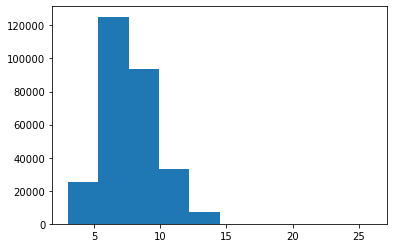

In [13]:
# I will now plot some data exploration plots, such as distribution of number of holds and grades

# Plot histogram of problem lengths
plt.hist(problem_lengths)

(array([92246., 70906., 39193., 30393., 30338., 13343.,  4774.,  2178.,
          649.,   627.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

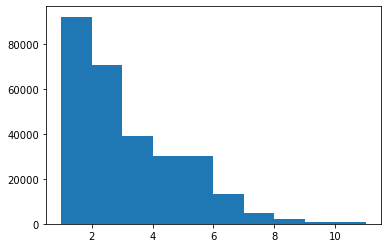

In [14]:
# Plot histogram of grades
plt.hist(problem_grades)

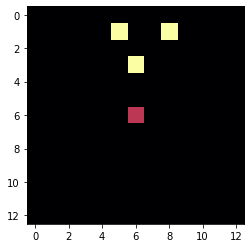

In [15]:
# Samples of the 12 submatrices of size 13x13 that constitute the input to the network
plt.imshow(problems_train[0][0], cmap='inferno')

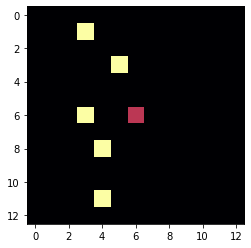

In [16]:
plt.imshow(problems_train[0][1], cmap='inferno')